In [7]:
!git clone https://github.com/imostafizur/CSE498R.git

fatal: destination path 'CSE498R' already exists and is not an empty directory.


## Pneumonia Detection with EfficientNet-B7

In [8]:
#EfficientNet-B7
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [9]:
image = ('Pneumonia')

In [10]:
# Count the number of images in Pneumonia and Normal folders
print('Total number of images in Pneumonia folder:', len(os.listdir('Pneumonia')))
print('Total number of images in Normal folder:',
      len(os.listdir('Pneumonia/NORMAL')))
print('Total number of images in Pneumonia folder:',
      len(os.listdir('Pneumonia/PNEUMONIA')))


Total number of images in Pneumonia folder: 2
Total number of images in Normal folder: 1342
Total number of images in Pneumonia folder: 3876


In [11]:
# EfficientNet-B7
IMG_SIZE = 600
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest',
                                        validation_split=0.2)

In [12]:
# Training data
train_generator = train_datagen.flow_from_directory(
    'Pneumonia',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training')

Found 4173 images belonging to 2 classes.


In [13]:
# Validation data
validation_generator = train_datagen.flow_from_directory(
    'Pneumonia',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation')

Found 1043 images belonging to 2 classes.


In [14]:
# Create the base model from the pre-trained model EfficientNetB7
base_model = EfficientNetB7(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                 include_top=False,
                                    weights='imagenet')

258088960/258076736 [==============================] - 3s 0us/step


In [15]:
# Freeze the base model
base_model.trainable = False


In [16]:
# Create new model on top
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

In [17]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 19, 19, 2560)     64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2561      
                                                                 
Total params: 64,100,248
Trainable params: 2,561
Non-trainable params: 64,097,687
_________________________________________________________________


In [19]:
# Callbacks
earlystop = EarlyStopping(monitor='val_loss', patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,     
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[earlystop, learning_rate_reduction])

Epoch 1/20
131/131 [==============================] - 588s 4s/step - loss: 0.6091 - accuracy: 0.6798 - val_loss: 0.5701 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 2/20
131/131 [==============================] - 539s 4s/step - loss: 0.5721 - accuracy: 0.7429 - val_loss: 0.5702 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.5706 - accuracy: 0.7429
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
131/131 [==============================] - 537s 4s/step - loss: 0.5706 - accuracy: 0.7429 - val_loss: 0.5708 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 4/20
131/131 [==============================] - 540s 4s/step - loss: 0.5716 - accuracy: 0.7429 - val_loss: 0.5699 - val_accuracy: 0.7430 - lr: 5.0000e-05
Epoch 5/20
131/131 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.7429
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
131/131 [==================

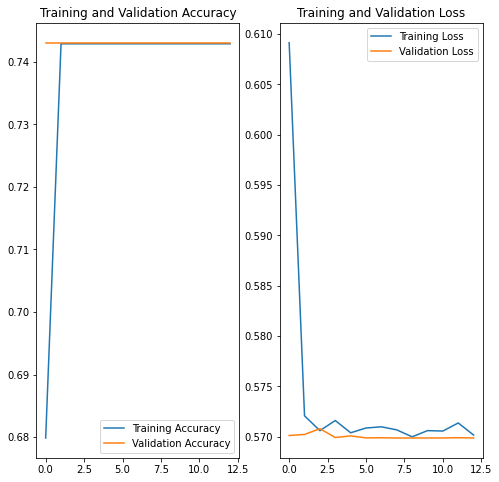

In [21]:
# Plot the training and validation accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# Save the model
model.save('Pneumonia_Efficientnet-B7.h5')